# Baseline scores

In [36]:
import numpy as np
import os
from matplotlib import pyplot as plt
import xarray as xr
import xskillscore as xs
import skimage
import pandas as pd
import seaborn as sns
import math
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error
path = "/work/FAC/FGSE/IDYST/tbeucler/downscaling/Downscaling_CM/utils"
os.chdir(path)
import metrics
import dataset
import rescaling
sns.set(style="darkgrid")
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

In [37]:
sns.set(style="darkgrid")

In [38]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

Let's get the files

In [39]:
path = "/work/FAC/FGSE/IDYST/tbeucler/downscaling/HadGEM_driven_COSMO/Present/2003"
os.chdir(path)
filenames = dataset.getfiles()
print(filenames[0:24])

['lffd20030101000000.nc', 'lffd20030101010000.nc', 'lffd20030101020000.nc', 'lffd20030101030000.nc', 'lffd20030101040000.nc', 'lffd20030101050000.nc', 'lffd20030101060000.nc', 'lffd20030101070000.nc', 'lffd20030101080000.nc', 'lffd20030101090000.nc', 'lffd20030101100000.nc', 'lffd20030101110000.nc', 'lffd20030101120000.nc', 'lffd20030101130000.nc', 'lffd20030101140000.nc', 'lffd20030101150000.nc', 'lffd20030101160000.nc', 'lffd20030101170000.nc', 'lffd20030101180000.nc', 'lffd20030101190000.nc', 'lffd20030101200000.nc', 'lffd20030101210000.nc', 'lffd20030101220000.nc', 'lffd20030101230000.nc']


Let's now work with the values for an entire week

In [40]:
day_2km = dataset.new_dataset(filenames, 172, 173)
path = "/work/FAC/FGSE/IDYST/tbeucler/downscaling/Downscaling_CM/data"
day_2km = day_2km.drop('lon')
day_2km = day_2km.drop('lat')
os.chdir(path)
day_2km

<xarray.Dataset>
Dimensions:     (time: 24, rlon: 1542, rlat: 1542)
Coordinates:
  * time        (time) datetime64[ns] 2003-06-22 ... 2003-06-22T23:00:00
  * rlon        (rlon) float32 -18.86 -18.84 -18.82 -18.8 ... 11.92 11.94 11.96
  * rlat        (rlat) float32 -14.86 -14.84 -14.82 -14.8 ... 15.92 15.94 15.96
    height_2m   float32 2.0
    height_10m  float32 10.0
Data variables:
    T_2M        (time, rlat, rlon) float32 293.9 293.9 293.9 ... 283.5 283.5
    RELHUM_2M   (time, rlat, rlon) float32 79.83 79.32 79.08 ... 79.15 79.35
    TOT_PR      (time, rlat, rlon) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    standard_name:  air_temperature
    long_name:      2m temperature
    units:          K
    grid_mapping:   rotated_pole

In [41]:
dataset.save_dataset(day_2km, 'day_2km')

saving to  ./day_2km.nc
finished saving


In [42]:
lat_bnd = [-4, 2]
lon_bnd = [-4, 5]

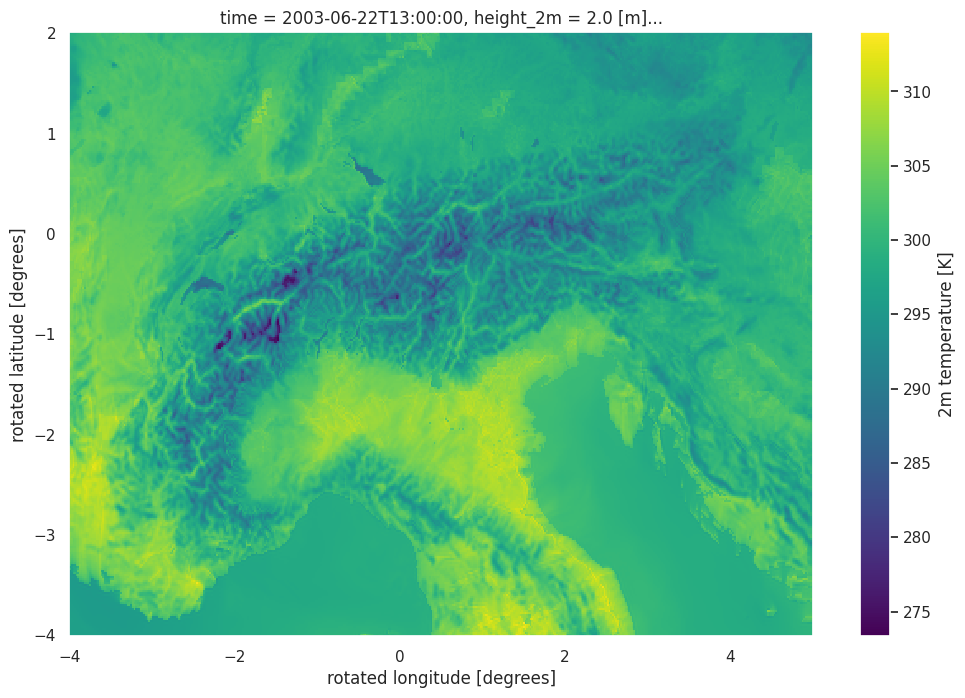

In [43]:
day_2km.T_2M.sel(rlon=slice(*lon_bnd), rlat=slice(*lat_bnd)).isel(time = 13).plot()

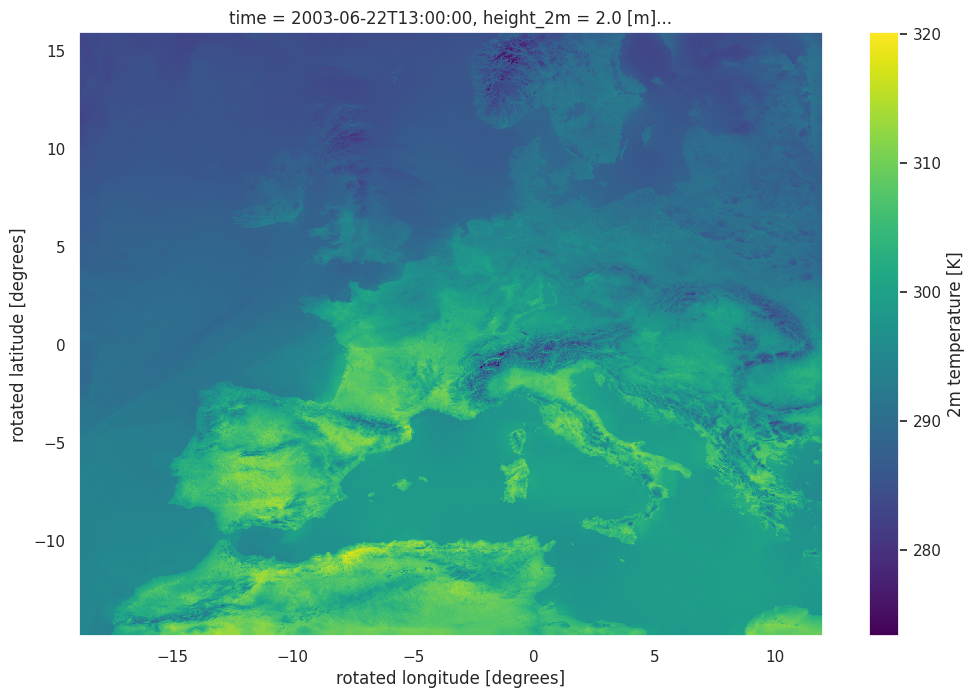

In [44]:
day_2km.T_2M.isel(time = 13).plot()

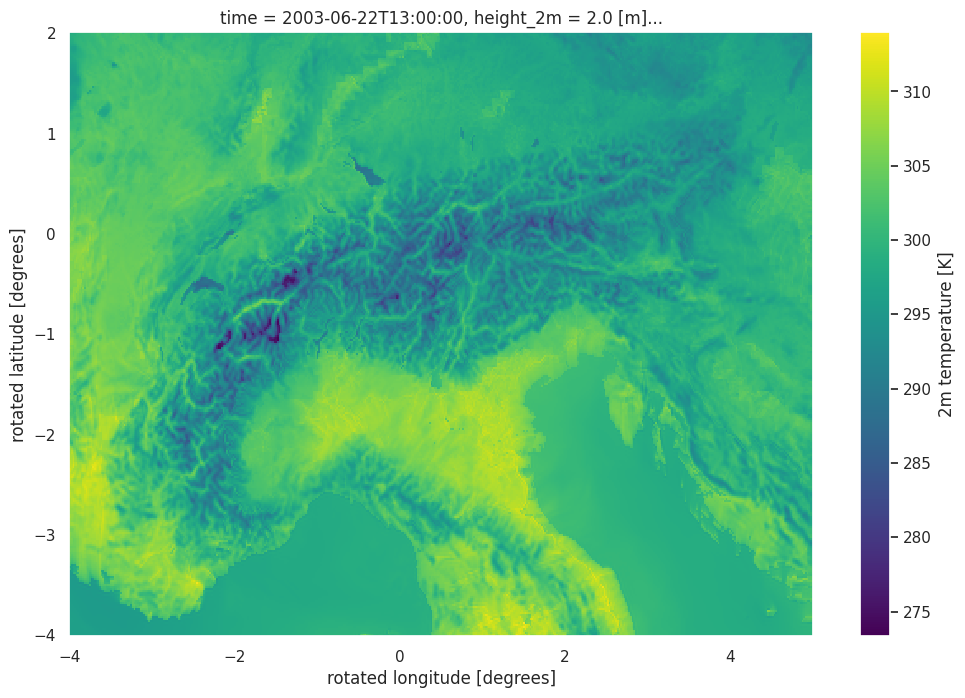

In [45]:
day_2km.T_2M.sel(rlon=slice(*lon_bnd), rlat=slice(*lat_bnd)).isel(time = 13).plot()

In this notebook, it will be interesting to look at the different metrics that can be used, to see how the baselines are performing

6 metrics will be used to compare the downscalings : RMSE, MAE, SSIM, spatial autocorrelation, Hellinger distance and Perkins score. We will compare the downscaled images with the original image

## Data preparation

### Upscaling

In [46]:
ingrid = rescaling.create_grid(-18.86, 11.98, 0.02, -14.86, 15.98, 0.02)
outgrid = rescaling.create_grid(-18.86, 11.9, 0.12, -14.86, 15.9, 0.12)

In [47]:
ups_ds = rescaling.upscale(day_2km, ingrid, outgrid)

Overwrite existing file: conservative_1542x1542_257x257.nc 
 You can set reuse_weights=True to save computing time.
using dimensions ('rlat', 'rlon') from data variable T_2M as the horizontal dimensions for this dataset.


/work/FAC/FGSE/IDYST/tbeucler/downscaling/Downscaling_CM/env/lib/python3.7/site-packages/xesmf/frontend.py:486: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


saving to  ./day_12km.nc
finished saving


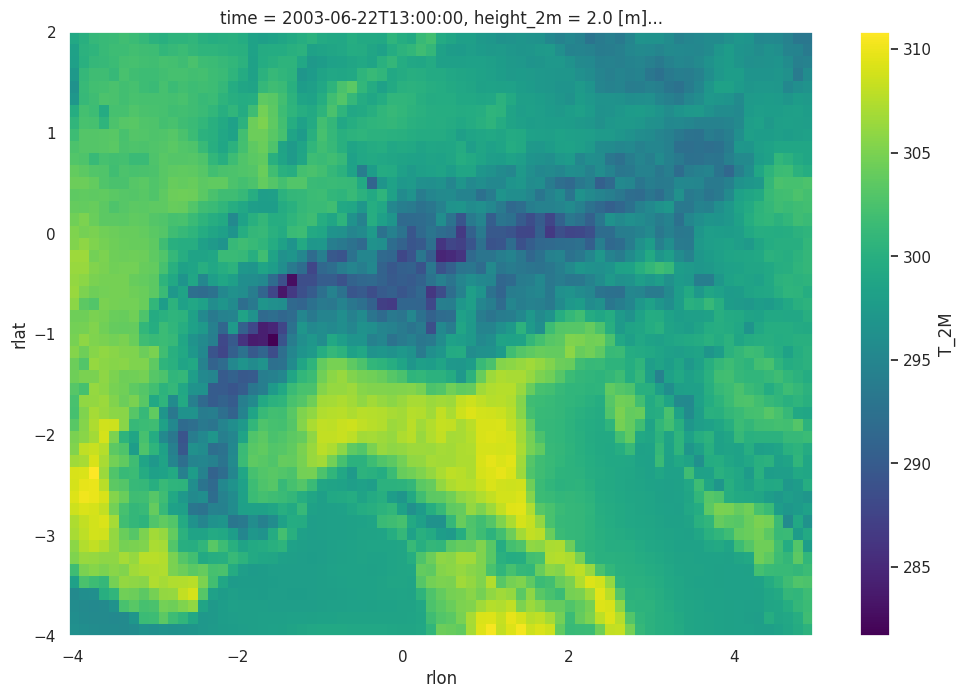

In [48]:
ups_ds.T_2M.sel(rlon=slice(*lon_bnd), rlat=slice(*lat_bnd)).isel(time = 13).plot()
dataset.save_dataset(ups_ds, 'day_12km')

### Downscaling

Let's do bilinear remapping, bicubic and quintic

In [49]:
bilin_2km = xr.full_like(day_2km, 0)
rescaling.downscale(ups_ds, bilin_2km, -18.86, 11.9, 0.12, -14.86, 15.9, 0.12, 11.98,0.02, 15.98, 0.02, 'linear')

<xarray.Dataset>
Dimensions:     (time: 24, rlat: 1542, rlon: 1542)
Coordinates:
    height_2m   float32 2.0
    height_10m  float32 10.0
  * time        (time) datetime64[ns] 2003-06-22 ... 2003-06-22T23:00:00
  * rlon        (rlon) float32 -18.86 -18.84 -18.82 -18.8 ... 11.92 11.94 11.96
  * rlat        (rlat) float32 -14.86 -14.84 -14.82 -14.8 ... 15.92 15.94 15.96
Data variables:
    T_2M        (time, rlat, rlon) float32 293.9 293.9 293.9 ... 283.8 283.8
    RELHUM_2M   (time, rlat, rlon) float32 79.63 79.99 80.35 ... 78.44 78.44
    TOT_PR      (time, rlat, rlon) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    standard_name:  air_temperature
    long_name:      2m temperature
    units:          K
    grid_mapping:   rotated_pole

saving to  ./bilin_day.nc
finished saving


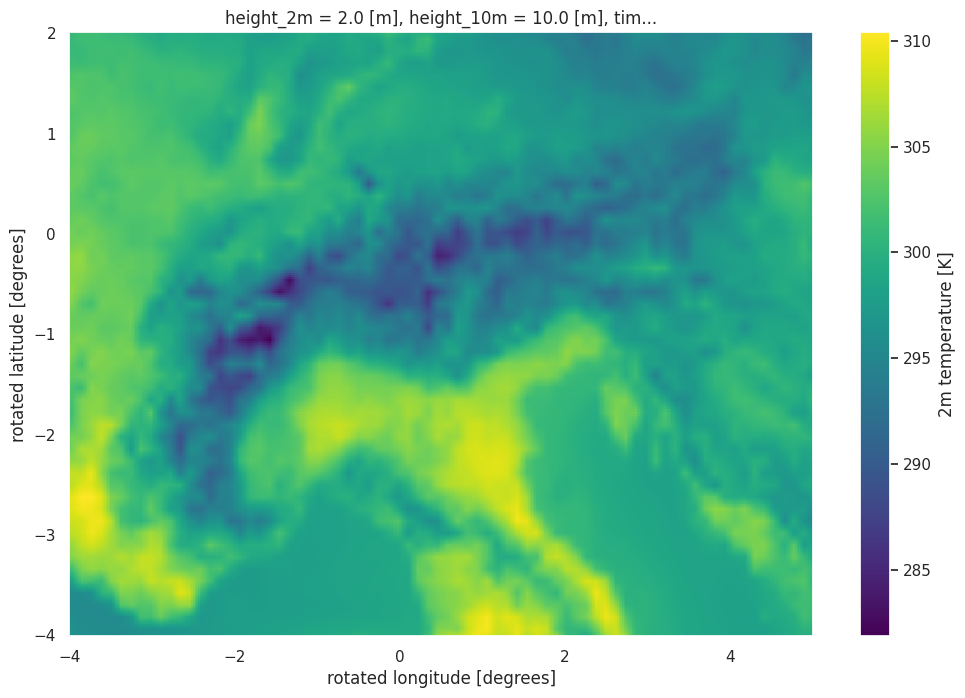

In [50]:
dataset.save_dataset(bilin_2km, 'bilin_day')
bilin_2km.T_2M.sel(rlon=slice(*lon_bnd), rlat=slice(*lat_bnd)).isel(time = 12).plot()

In [51]:
bicubic_2km = xr.full_like(day_2km, 0)
rescaling.downscale(ups_ds, bicubic_2km, -18.86, 11.9, 0.12, -14.86, 15.9, 0.12, 11.98,0.02, 15.98, 0.02, 'cubic')
dataset.save_dataset(bicubic_2km, 'bicubic_day')

saving to  ./bicubic_day.nc
finished saving


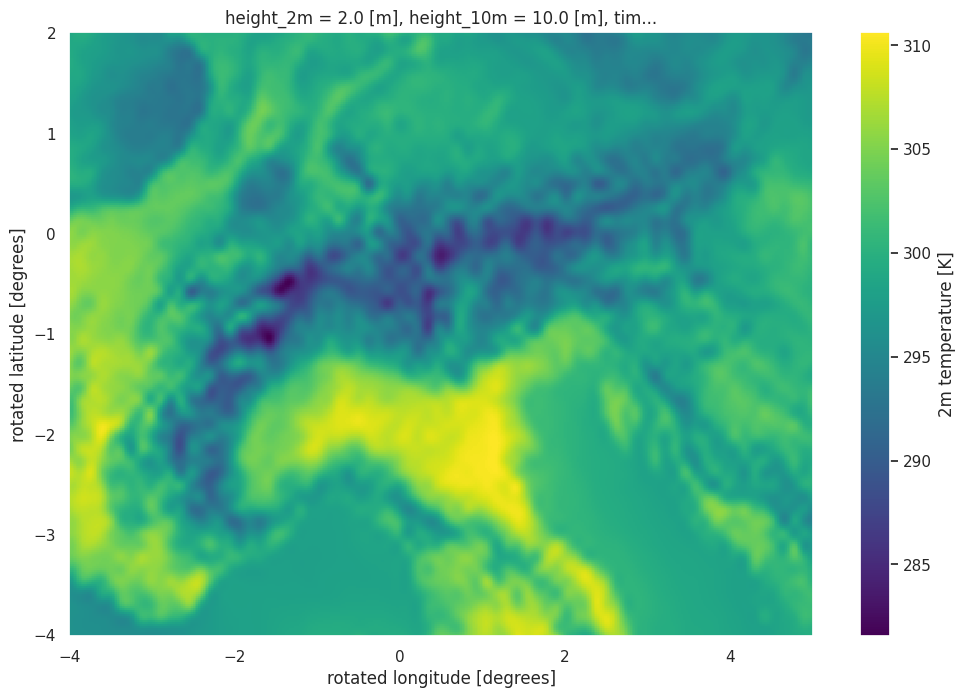

In [52]:
bicubic_2km.T_2M.sel(rlon=slice(*lon_bnd), rlat=slice(*lat_bnd)).isel(time = 15).plot()

In [53]:
quintic_2km = xr.full_like(day_2km, 0)
rescaling.downscale(ups_ds, quintic_2km, -18.86, 11.9, 0.12, -14.86, 15.9, 0.12, 11.98,0.02, 15.98, 0.02, 'quintic')
dataset.save_dataset(quintic_2km, 'quintic_day')

saving to  ./quintic_day.nc
finished saving


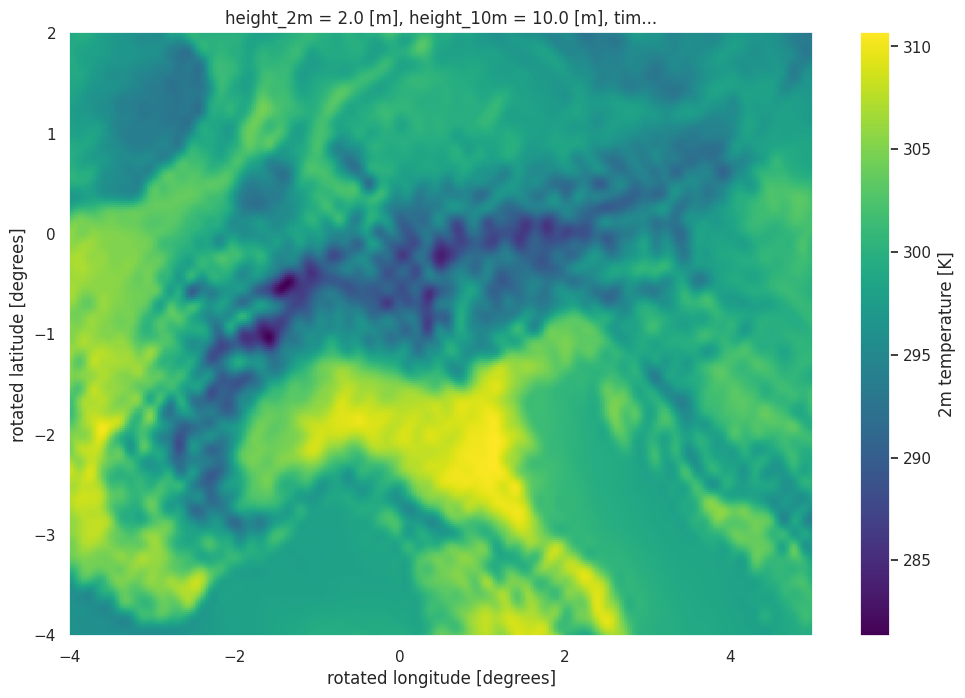

In [54]:
quintic_2km.T_2M.sel(rlon=slice(*lon_bnd), rlat=slice(*lat_bnd)).isel(time = 15).plot()

In [55]:
day_all = [day_2km, bilin_2km, bicubic_2km, quintic_2km]

# RMSE 

It is one of the easiest metrics

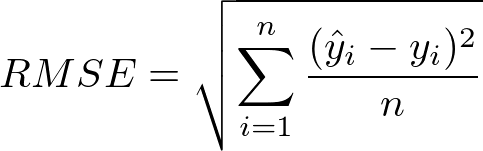

In [56]:
bil_RMSE = xs.rmse(day_2km, bilin_2km, dim = ['rlon','rlat'])
bic_RMSE = xs.rmse(day_2km, bicubic_2km, dim = ['rlon','rlat'])
quintic_RMSE = xs.rmse(day_2km, quintic_2km, dim = ['rlon','rlat'])

RMSE = [bil_RMSE, bic_RMSE, quintic_RMSE]

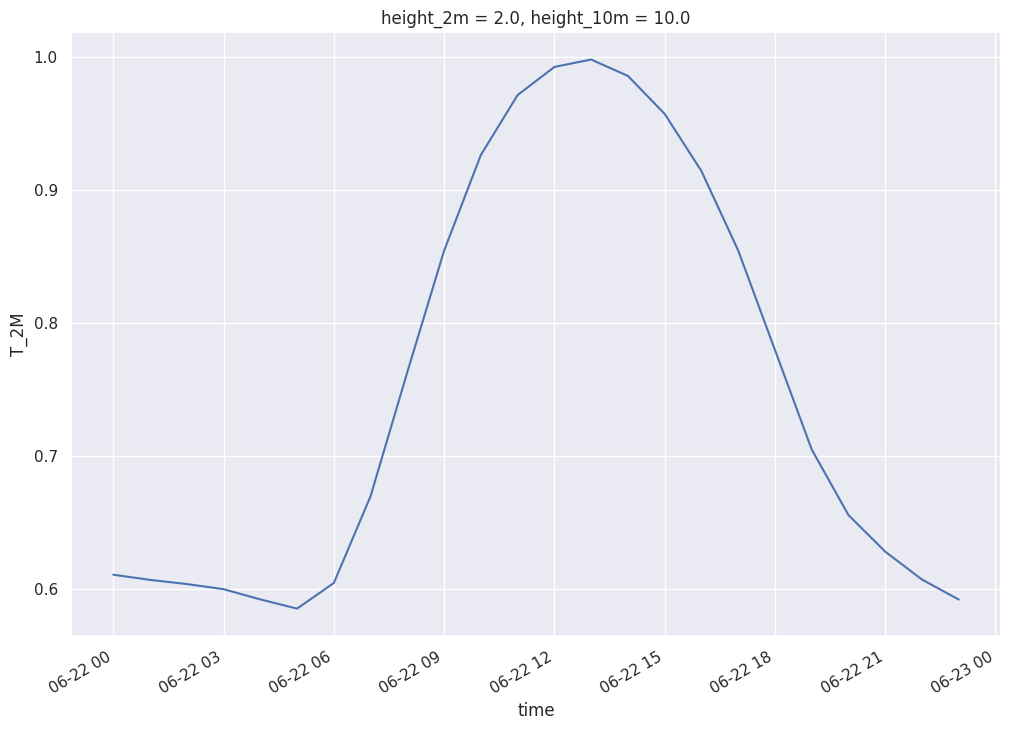

In [57]:
bil_RMSE.T_2M.plot()

In [58]:
1 - np.mean(bil_RMSE.T_2M.values)

0.2475762963294983

# MAE

Easy to understand too 

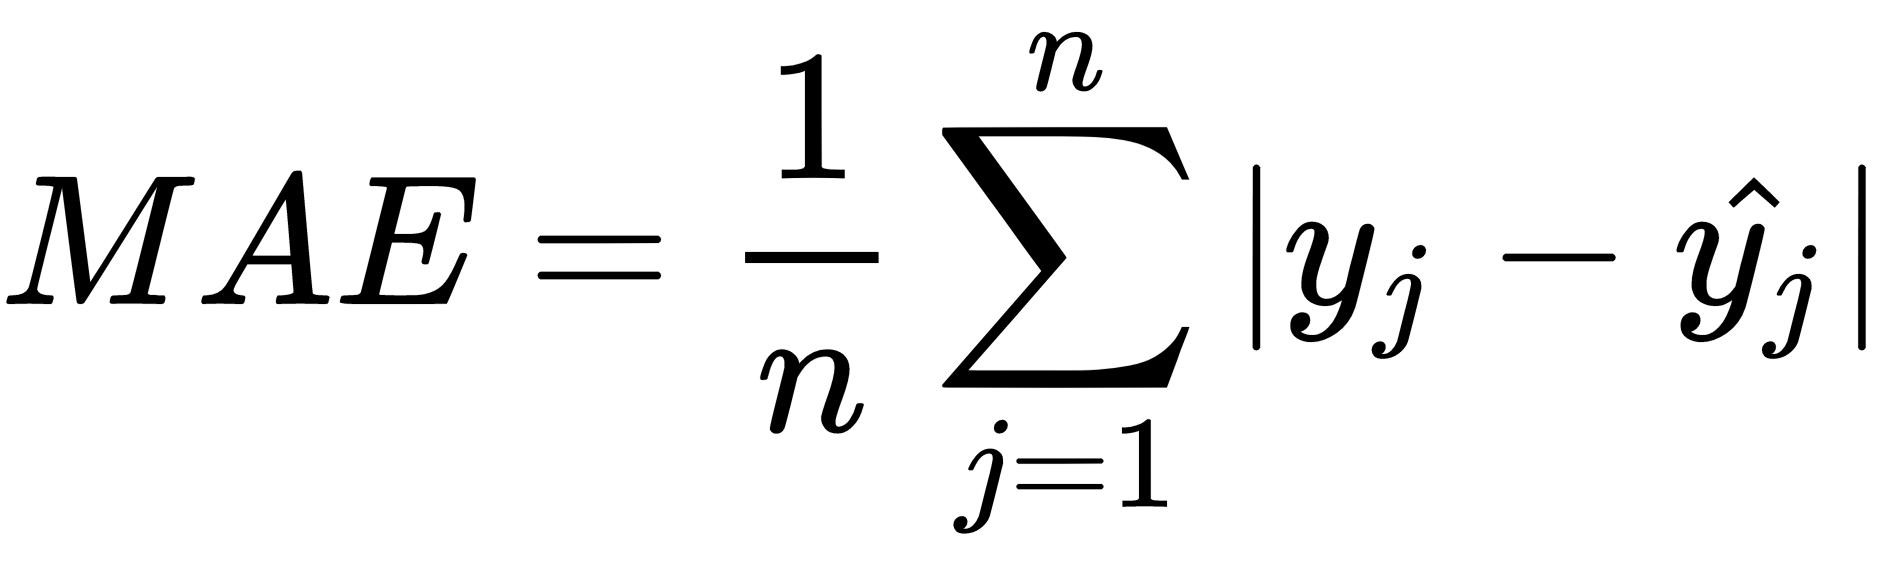

In [22]:
bil_MAE = xs.mae(day_2km, bilin_2km, dim = ['rlon','rlat'])
bic_MAE = xs.mae(day_2km, bicubic_2km, dim = ['rlon','rlat'])
quintic_MAE = xs.mae(day_2km, quintic_2km, dim = ['rlon','rlat'])

MAE = [bil_MAE, bic_MAE,quintic_MAE]

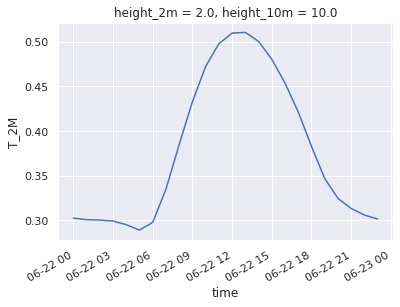

In [23]:
bil_MAE.T_2M.plot()

# SSIM

This website is quite clear on how it works (plus code) : https://medium.com/srm-mic/all-about-structural-similarity-index-ssim-theory-code-in-pytorch-6551b455541e

In [24]:
bil_SSIM = metrics.SSIM(day_2km, bilin_2km)
bic_SSIM = metrics.SSIM(day_2km, bicubic_2km)
quintic_SSIM = metrics.SSIM(day_2km, quintic_2km)

Norm_SSIM = [1-bil_SSIM, 1-bic_SSIM, 1-quintic_SSIM]

KeyboardInterrupt: 

In [ ]:
bil_SSIM.T_2M.plot()

# Hellinger distance

I didn't found a function for the Helllinger distance, so I tried to do one following wikipedia's discrete distribution :
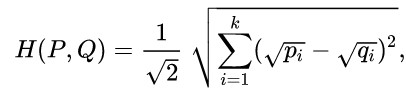

For the function to work faster, try to play with the matrix directly

In [ ]:
bil_H = metrics.discrete_Hellinger(day_2km, bilin_2km)

In [ ]:
bil_H.T_2M.plot()

According to Tom, it is better to do a continuous function. I am doing this function (still from wikipedia), and I'm now normalizing the value of the error.
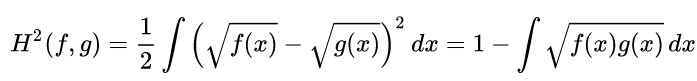

In [ ]:
H_bilin = metrics.Hellinger(day_2km, bilin_2km)
H_bilin.T_2M.plot()

# Perkins score

Perkins skill score is quite unknown. We have the formula from the paper X :

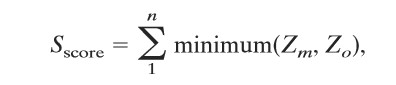

Where n is the number of bins (here 119), Zm the freq of values in a given bin and Zo the same freq but on the observed data. The Perkins skill score function created is continuous.

In [ ]:
P_bilin = metrics.Perkins(day_2km, bilin_2km)
P_bilin.T_2M.plot()

# Autocorrelation 

## Temporal autocorrelation

At first, let's try the temp autocorr on a random variable from the og model. 

In [ ]:
xr.corr(day_2km.T_2M, day_2km.T_2M, dim = ["time"])

In [ ]:
Coordinates = {
    'time':(['time'], day_2km.time.values[:5]),
    'rlon':(['rlon'], day_2km["rlon"].values[:3]),
    'rlat':(['rlat'], day_2km["rlat"].values[:3])
} 

In [ ]:
x = np.arange(45).reshape((5,3,3));
x[1] = x[3]
x[3] = x[3] - np.array([[4,6,2],[3,5,7],[9,6,1]])
x[2] = x[2] + np.array([[-4,36,22],[43,-5,7],[2,-2,1]])
Variables = {
    'T_2M':(['time','rlat','rlon'], x)
}
test = xr.Dataset(Variables, Coordinates)
x2 = x
x2[0] = x2[1] + np.array([[4,5,2],[3,5,7],[9,-6,1]])
x2[4] = x2[4] - np.array([[-4,3,22],[43,-5,-7],[2,-2,1]])
Variables2 = {
    'T_2M':(['time','rlat','rlon'], x2)
}
test2 = xr.Dataset(Variables2, Coordinates)


In [ ]:
xr.corr(test.T_2M,test2.T_2M,dim = "time")

Here, how to transform a dataset iot have an array per time value

In [ ]:
new = np.array([test.T_2M.values[i].flatten() for i in range(len(test.T_2M))])
new

In [ ]:
correl = np.corrcoef(new); correl

In [ ]:
lag = 2
ntest = []
mat= []
for i in range(lag+1) : 
    for j in range(len(new)-lag):
        ntest.append(correl[j+i,j])
        mat.append(i)
np.sum(ntest[6:9])/3

In [ ]:
data = {'lag':  mat,
        'corr': ntest
        }

df = pd.DataFrame(data)

In [ ]:
sns.lineplot(data=df, x="lag", y="corr")

Each diag represent a diff lag autocorrelation. I should try to do a function that can draw the correlation depending on the lags, with intervalle de conf

In [ ]:
metrics.corr(test, "time", 2, 1)

In [ ]:
lag = 22
t = metrics.corr(day_2km, "time", lag, 1)
sns.lineplot(data=t, x="lag", y="corr")

In [ ]:
lag = 24
t = metrics.corr(bilin_2km, "time", lag, 1)
sns.lineplot(data=t, x="lag", y="corr")

## Spatial autocorrelation

In [ ]:
test.T_2M.values

In [ ]:
test.T_2M.values[:,1:,:]

In [ ]:
lag_ds = test.T_2M.values[:,1:,:]
lon_ds = test.T_2M.values[:,:-1,:]
lag = 2
lag_new = [np.array([test.T_2M.values[i,j:,:].flatten() for i in range(len(test.T_2M.values))]) for j in range(1,lag+1)]
print(lag_new) #lag 1 jour 0
lon_new = [np.array([test.T_2M.values[i,:-j,:].flatten() for i in range(len(test.T_2M.values))]) for j in range(1,lag+1)]
lon_new

In [ ]:
lon_correl = np.corrcoef([lag_new[0][0], lon_new[0][0]])
lon_correl

In [ ]:
lag = 700
step = 1
df = metrics.corr(day_2km, "rlon", lag, step)
sns.lineplot(data= df, x="lag", y="corr")

In [ ]:
df_bil = metrics.corr(bilin_2km, "rlon", lag, step)
sns.lineplot(data= df_bil, x="lag", y="corr")

In [ ]:
df = metrics.corr(day_2km, "rlat", lag, step)
sns.lineplot(data=df, x="lag", y="corr")

## Omnidirectional autocorrelation

# Pdf, histogram and ploting (useless now)

## trapz test

In [ ]:
from scipy.stats import norm
from scipy.stats import uniform

In [ ]:
fig, axis = plt.subplots(1, 1)
x = np.linspace(-1,
                2, 5000)
axis.plot(x, uniform.pdf(x+0.5),'r-', lw=2, label='uniform pdf')
axis.plot(x, uniform.pdf(x), 'k-', lw=2, label='frozen pdf')
len(x)

In [ ]:
f1 = uniform.pdf(x)
f2 = uniform.pdf(x+0.5)
1-np.trapz(f2, x)

In [ ]:
def testtrap(pdf1, pdf2, bins) :
    return 1 - np.trapz(np.sqrt(np.multiply(pdf1,pdf2)),bins)
testtrap(f1,f2, x)

In [ ]:
def testPerkins(pdf1,pdf2,bins) :
#    vect_min = np.minimum(pdf1, pdf2)
#    score = np.trapz(vect_min, bins)
    return np.trapz(np.minimum(pdf1, pdf2), bins)

## Histogram from temperature (using numpy)

In [ ]:
test1 = day_2km.T_2M.isel(time = 0)
test2 = bilin_2km.T_2M.isel(time = 0)
bins = np.linspace(270,320,3000)

In [ ]:
hist1, bins1 = np.histogram(test1.values, bins, density = True) # density normalize the integral
hist2, bins2 = np.histogram(test2.values, bins, density = True)
hist2.sum()

In [ ]:
#plt.bar(bins1[1:], hist1, width = widths1)
plt.plot(bins[1:], hist1, '-r')
plt.plot(bins[1:], hist2)

### Hellinger

In [ ]:
np.sqrt(testtrap(hist1, hist1, bins[1:]))

### Perkins

In [ ]:
import metrics

In [ ]:
testPerkins(hist1, hist2, bins[1:])

## Ploting

### Multiplot

Let's try things with the RMSE

In [ ]:
RMSE[0].T_2M.plot(label = "bilinear")
RMSE[1].T_2M.plot(label = "bicubic")
RMSE[2].T_2M.plot(label = "quintic")
plt.legend()
RMSE[0].time.values

In [ ]:
math.sqrt(np.size(day_2km.T_2M.isel(time = 0).values))

In [ ]:
method = ["bilinear", "bicubic", "quintic"]
metrics.multi_plot(Norm_SSIM, method, "1 - SSIM")

### Scatterplot 

In [ ]:
plt.scatter(day_2km.TOT_PR.values, bilin_2km.TOT_PR.values, marker='o', s = 1, alpha = 0.05)

In [ ]:
day_2km.plot.scatter('RELHUM_2M', 'TOT_PR', marker='o', s = 0.7, alpha = 0.05)

In [ ]:
method = ["None", "bilinear", "bicubic", "quintic"]
metrics.multi_scatterplot(day_all, method, 'RELHUM_2M', 'TOT_PR')

# Seaborn

In [73]:
test1 = day_2km.T_2M.isel(time = 0)
test2 = bilin_2km.T_2M.isel(time = 0)
bins = np.linspace(270,320,3000)

In [74]:
hist1, bins1 = np.histogram(test1.values, bins, density = True) # density normalize the integral
hist2, bins2 = np.histogram(test2.values, bins, density = True)
hist2.sum()

59.97999999999983

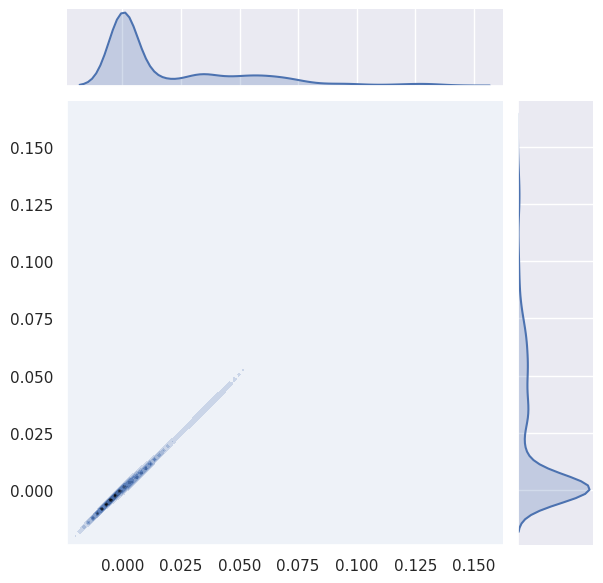

In [75]:
sns.jointplot(hist1,hist2, kind="kde")


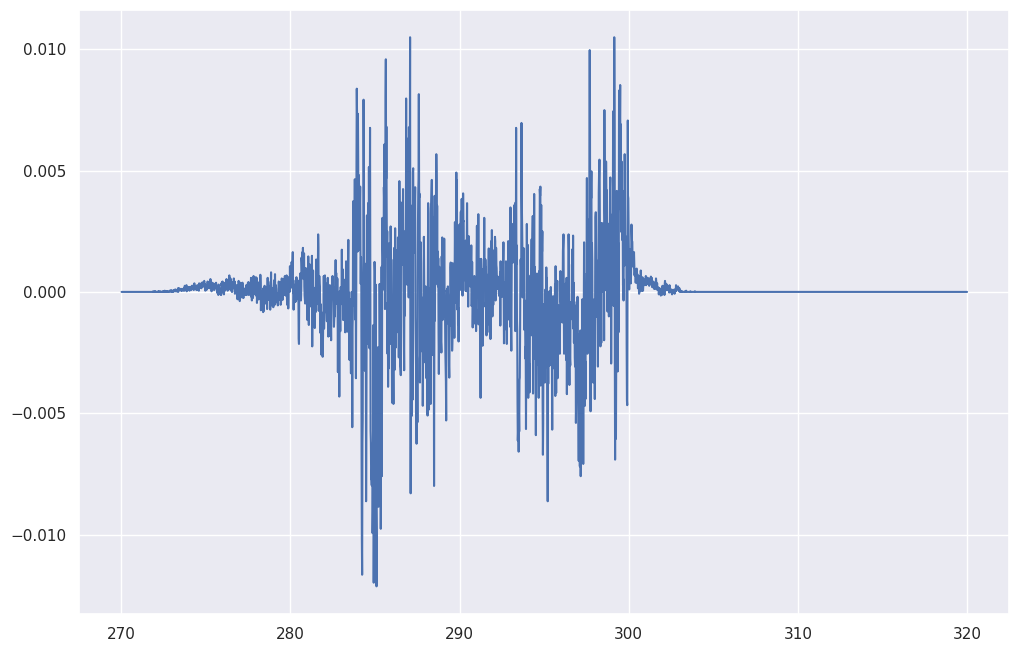

In [62]:
sns.lineplot(bins[1:], hist1 - hist2)
plt.show()